In [11]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("="*75)
print("DISPLAYING A PREVIEW OF THE RAW DATASET")
print("="*75)

try:
    # Set pandas options to display more columns, otherwise key info might be hidden
    pd.set_option('display.max_columns', 50)
    pd.set_option('display.width', 1000)

    # Load the raw dataset again to show its original state
    raw_df = pd.read_csv(r"data.csv", delimiter=';', encoding='windows-1254')
    
    # Display the first 10 rows
    print("\nShowing the first 10 rows of the raw 'data.csv' file:\n")
    print(raw_df.head(10))

    print("\n" + "="*75)
    print("DATASET COLUMNS")
    print("="*75)
    print(raw_df.columns.to_list())

except FileNotFoundError:
    print("\nError: 'data.csv' not found.")
    print("Please make sure the file is in the correct directory.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")


DISPLAYING A PREVIEW OF THE RAW DATASET

Showing the first 10 rows of the raw 'data.csv' file:

   Group  Sex  Age  Patients number per hour  Arrival mode  Injury         Chief_complain  Mental  Pain NRS_pain  SBP  DBP   HR  RR    BT Saturation  KTAS_RN                                    Diagnosis in ED  Disposition  KTAS_expert  Error_group  Length of stay_min KTAS duration_min  mistriage
0      2    2   71                         3             3       2      right ocular pain       1     1        2  160  100   84  18  36.6        100        2                                   Corneal abrasion            1            4            2                  86              5,00          1
1      1    1   56                        12             3       2     right forearm burn       1     1        2  137   75   60  20  36.5        NaN        4                  Burn of hand, firts degree dorsum            1            5            4                  64              3,95          1
2      2    1

In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer # <-- Added this import
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# --- Keyword-based Feature Engineering Function ---
def calculate_severity_score(text):
    """Enhanced keyword-based severity scoring"""
    score = 0
    text = str(text).lower()

    critical = {
        'arrest': 25, 'unconscious': 20, 'cpr': 25, 'hemorrhage': 18,
        'infarction': 18, 'stroke': 20, 'seizure': 16, 'anaphylaxis': 18,
        'shock': 20, 'paralysis': 18, 'hemiparesis': 16, 'code': 25
    }
    high = {
        'dyspnea': 12, 'chest pain': 14, 'hematemesis': 13, 'melena': 12,
        'syncope': 12, 'bleeding': 12, 'confusion': 13, 'acute': 11
    }
    moderate = {
        'fever': 6, 'vomiting': 6, 'headache': 5, 'dizzy': 5, 'diarrhea': 5,
        'laceration': 6, 'burn': 7, 'pain': 3, 'rash': 4
    }
    
    for keyword, value in {**critical, **high, **moderate}.items():
        if re.search(r'\b' + re.escape(keyword) + r'\b', text):
            score += value
    
    return score


def engineer_features(df):
    """Clinical feature engineering"""
    
    # Clean vitals
    for col in ['SBP', 'DBP', 'HR', 'RR', 'Saturation', 'BT']:
        if col in df.columns:
            df[col] = df[col].replace(0, np.nan).fillna(df[col].median())
    
    # Derived vitals
    df['shock_index'] = df['HR'] / (df['SBP'] + 1)
    df['map'] = (df['SBP'] + 2 * df['DBP']) / 3
    df['pulse_pressure'] = df['SBP'] - df['DBP']
    
    # Count abnormal vitals
    df['abnormal_vitals'] = (
        ((df['SBP'] < 90) | (df['SBP'] > 180)) +
        ((df['HR'] < 50) | (df['HR'] > 120)) +
        ((df['RR'] < 10) | (df['RR'] > 24)) +
        (df['Saturation'] < 92) +
        ((df['BT'] < 36) | (df['BT'] > 38.5))
    ).astype(int)
    
    # Interactions
    df['severity_x_pain'] = df['severity_score'] * np.log1p(df['NRS_pain'])
    df['severity_x_mental'] = df['severity_score'] * (df['Mental'] != 1).astype(int)
    df['age_x_severity'] = (df['Age'] / 100) * df['severity_score']
    
    # Age risk
    df['high_risk_age'] = ((df['Age'] < 2) | (df['Age'] > 70)).astype(int)
    
    # Pain categories
    df['high_pain'] = (df['NRS_pain'] >= 7).astype(int)
    
    return df

# --- Custom Prediction Function with Thresholds ---
def predict_with_thresholds(probabilities, custom_thresholds):
    """
    Applies custom thresholds to probabilities for prediction.
    Class 0 (KTAS 1) is checked first.
    """
    preds = []
    for prob_row in probabilities:
        # Check high-priority classes first
        if prob_row[0] >= custom_thresholds.get(0, 0.5): # Check for KTAS 1 (index 0)
            preds.append(0)
        else:
            # If no custom threshold is met, predict the class with the highest probability
            preds.append(np.argmax(prob_row))
    return np.array(preds)


# --- Main ---
try:
    print("="*75)
    print("FINAL OPTIMIZED 4-CLASS XGBOOST (BALANCED TRAINING + THRESHOLDING)")
    print("="*75)
    
    df = pd.read_csv(r"data.csv", delimiter=';', encoding='windows-1254')
    print(f"\nDataset: {df.shape[0]} rows × {df.shape[1]} columns")

    # Preprocessing
    df.replace('#BOŞ!', np.nan, inplace=True)
    
    for col in ['KTAS duration_min', 'Length of stay_min']:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].str.replace(',', '.').astype(float)
    
    df['Chief_complain'] = df['Chief_complain'].fillna('')
    df['severity_score'] = df['Chief_complain'].apply(calculate_severity_score)
    
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'Chief_complain':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
    
    df.dropna(subset=['KTAS_expert'], inplace=True)

    # --- MERGE CLASS 4 AND 5 ---
    print("\nMerging KTAS classes 4 and 5 into a single class (4)...")
    df['KTAS_expert'] = df['KTAS_expert'].replace(5, 4)
    
    df = engineer_features(df)
    
    print("\nNew Class Distribution:")
    for cls in sorted(df['KTAS_expert'].unique()):
        count = (df['KTAS_expert'] == cls).sum()
        print(f"  KTAS {int(cls)}: {count:4d} ({count/len(df)*100:5.1f}%)")
    
    # Features
    numeric_features = [
        'Age', 'Sex', 'Group', 'Arrival mode', 'Injury', 'Mental', 
        'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation',
        'severity_score', 'shock_index', 'map', 'pulse_pressure',
        'abnormal_vitals', 'severity_x_pain', 'severity_x_mental',
        'age_x_severity', 'high_risk_age', 'high_pain'
    ]
    text_feature = 'Chief_complain'
    target = 'KTAS_expert'

    # Using a Pipeline to integrate preprocessing and classifier
    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('text', TfidfVectorizer(stop_words='english'), text_feature)
            ])),
        ('classifier', XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_jobs=-1))
    ])
    
    # Split Data
    X = df.drop(target, axis=1)
    y = (df[target].values - 1).astype(int) # 0-indexed for training (0,1,2,3)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Hyperparameter Grid for XGBoost
    param_grid = {
        'classifier__n_estimators': [400, 500],
        'classifier__max_depth': [5, 7],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'preprocessor__text__max_features': [250, None]
    }

    # GridSearchCV with standard F1-weighted scoring to find the best overall model
    print("\n" + "="*75)
    print("TUNING XGBOOST FOR BEST OVERALL F1-SCORE")
    print("="*75)
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='f1_weighted', verbose=2)
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters found: {grid_search.best_params_}")
    
    # Predict with the best model found
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)
    
    # --- APPLY CUSTOM THRESHOLD FOR PREDICTION ---
    print("\nApplying custom prediction threshold for KTAS 1...")
    # This threshold makes the model more sensitive to predicting class 0 (KTAS 1)
    custom_thresholds = {0: 0.25} # If prob for KTAS 1 is > 25%, predict KTAS 1
    y_pred = predict_with_thresholds(y_pred_proba, custom_thresholds)
    
    # --- Results Section ---
    print("\n" + "="*75)
    print("FINAL RESULTS (WITH THRESHOLD TUNING)")
    print("="*75)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n{'Metric':<25} {'Score':<15}")
    print("-"*40)
    print(f"{'Accuracy':<25} {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"{'F1-Score (Weighted)':<25} {f1_weighted:.4f}")
    print(f"{'F1-Score (Macro)':<25} {f1_macro:.4f}")
    
    print("\n" + "="*75)
    print("CLASSIFICATION REPORT")
    print("-"*75)
    target_names = [f"KTAS {i}" for i in range(1, 5)] # Now 4 classes
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    
    print("\n" + "="*75)
    print("CONFUSION MATRIX")
    print("-"*75)
    cm = confusion_matrix(y_test, y_pred)
    classes = sorted(np.unique(y_test))
    
    print("\n          Predicted KTAS")
    print("Actual    ", "   ".join([f"{int(c)+1:3d}" for c in classes]))
    print("----------------------------------------")
    for i, cls in enumerate(classes):
        print(f" KTAS {int(cls)+1}  {cm[i]}")

except ModuleNotFoundError as e:
    if 'xgboost' in str(e):
        print("\nERROR: XGBoost not found. Please install it by running: pip install xgboost")
    else:
        print(f"An error occurred: {e}")
except Exception as e:
    print(f"\nAn error occurred: {e}")
    import traceback
    traceback.print_exc()



FINAL OPTIMIZED 4-CLASS XGBOOST (BALANCED TRAINING + THRESHOLDING)

Dataset: 1267 rows × 24 columns

Merging KTAS classes 4 and 5 into a single class (4)...

New Class Distribution:
  KTAS 1:   26 (  2.1%)
  KTAS 2:  220 ( 17.4%)
  KTAS 3:  487 ( 38.4%)
  KTAS 4:  534 ( 42.1%)

TUNING XGBOOST FOR BEST OVERALL F1-SCORE
Fitting 3 folds for each of 64 candidates, totalling 192 fits

Best parameters found: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 400, 'classifier__subsample': 1.0, 'preprocessor__text__max_features': 250}

Applying custom prediction threshold for KTAS 1...

FINAL RESULTS (WITH THRESHOLD TUNING)

Metric                    Score          
----------------------------------------
Accuracy                  0.7559 (75.59%)
F1-Score (Weighted)       0.7525
F1-Score (Macro)          0.6648

CLASSIFICATION REPORT
---------------------------------------------------------------------------
       


VISUALIZING CLASS DISTRIBUTION


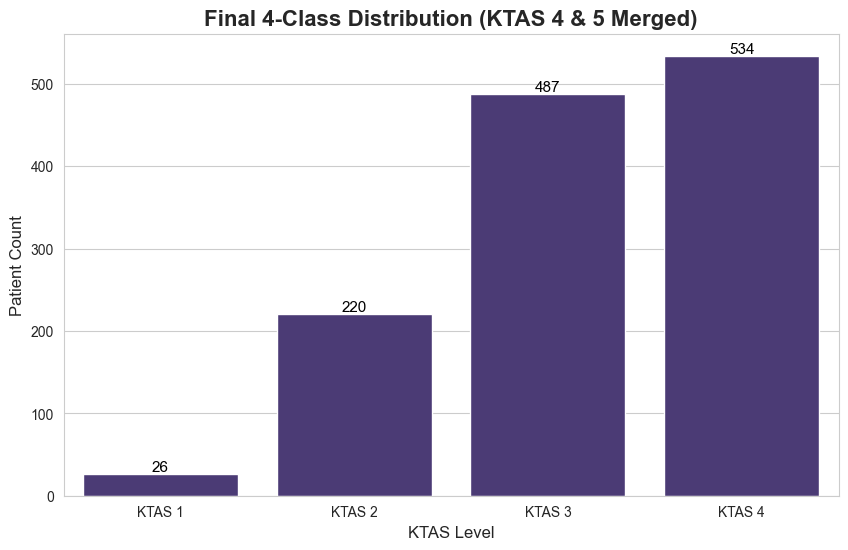


VISUALIZING TOP 20 FEATURE IMPORTANCES


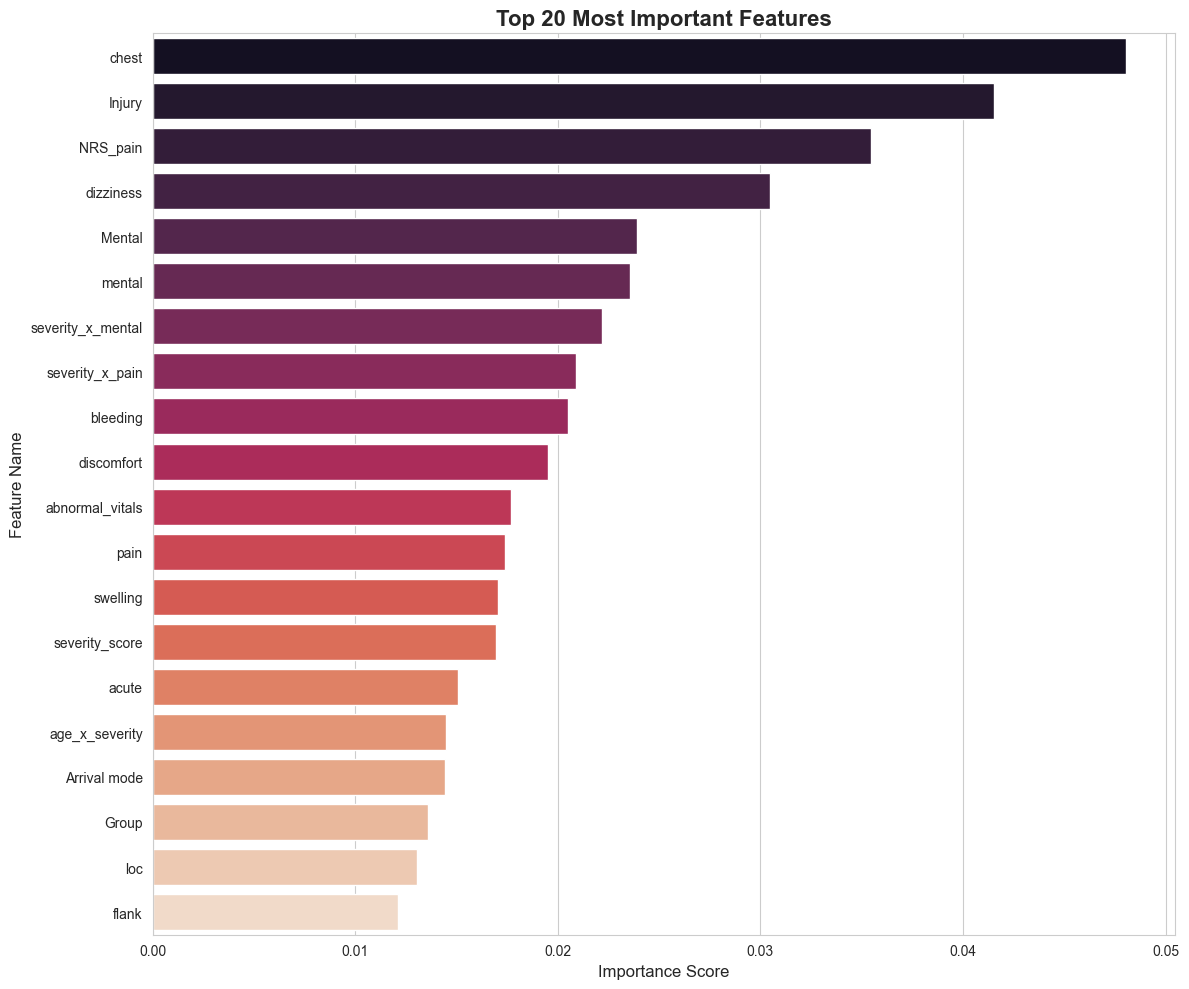

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set a professional style for the plots
sns.set_style("whitegrid")
sns.set_palette("viridis")

try:
    # --- 1. Class Distribution Plot ---
    
    print("\n" + "="*75)
    print("VISUALIZING CLASS DISTRIBUTION")
    print("="*75)
    
    # Use the 'df' DataFrame that was processed in the first cell
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=df['KTAS_expert'], order=sorted(df['KTAS_expert'].unique()))
    
    # Add labels and title
    plt.title('Final 4-Class Distribution (KTAS 4 & 5 Merged)', fontsize=16, fontweight='bold')
    plt.xlabel('KTAS Level', fontsize=12)
    plt.ylabel('Patient Count', fontsize=12)
    ax.set_xticklabels([f"KTAS {int(tick.get_text())}" for tick in ax.get_xticklabels()])
    
    # Add count labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.show()

    
    # --- 2. Feature Importance Plot ---
    
    print("\n" + "="*75)
    print("VISUALIZING TOP 20 FEATURE IMPORTANCES")
    print("="*75)
    
    # Extract the classifier and preprocessor from the 'best_model' (pipeline)
    classifier = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']
    
    # Get text feature names from the TfidfVectorizer
    text_features = preprocessor.transformers_[1][1].get_feature_names_out()
    
    # Combine numeric and text feature names
    all_feature_names = numeric_features + list(text_features)
    
    # Get importances
    importances = classifier.feature_importances_
    
    # Create a DataFrame for easy plotting
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    
    # Sort by importance and get the top 20
    top_20_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)
    
    # Plot as a horizontal bar chart
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', 
                y='feature', 
                data=top_20_features, 
                palette='rocket')
    
    plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)
    plt.tight_layout() # Adjust layout to prevent labels from being cut off
    plt.show()

except NameError as e:
    print(f"Error: A necessary variable was not found (e.g., 'df', 'cm', 'best_model', 'numeric_features').")
    print("Please make sure you have successfully run the main training script in the cell above this one.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

